# Conquering the Impossible!

# By: Matthew Eimers, Marc Medina, and Daniel Quiñonez

![a.png](a.png)

## Import Necessary Packages

In [1]:
import pandas as pd
import re
import usaddress
import matplotlib.pyplot as plt
from functools import *
from jellyfish import jaro_winkler_similarity
from IPython.display import Image

In [48]:
# Important US Address Package
example = "205 AVENIDA DEL MAR UNIT 488 92674-6222."
usaddress.parse(example)

[('205', 'AddressNumber'),
 ('AVENIDA', 'StreetName'),
 ('DEL', 'StreetName'),
 ('MAR', 'StreetName'),
 ('UNIT', 'OccupancyType'),
 ('488', 'OccupancyIdentifier'),
 ('92674-6222.', 'ZipCode')]

## Create Address df's

In [44]:
# Upload raw/input address data to df
input_addresses = pd.read_csv('OrangeCountyAddresses.csv')
input_addr = input_addresses[0:1000];

# Upload existing/master address data to df
master_addr = pd.read_csv('OrangeCountyAddresses10k.csv')

master_addr.head(10)

,RecordID,MAK,BaseMAK,Address,Suite,City,State,ZipCode,ZipCodePlus4
0,1,8008006245,NaN,22382 Avenida Empresa,NaN,Rancho Santa Margarita,CA,92688,2112
1,2,2701924369,NaN,141 Innovation Dr,NaN,Irvine,CA,92617,3211
2,3,3513356198,NaN,8109 Palo Verde Rd,NaN,Irvine,CA,92617,5304
3,4,5922124462,2.701924e+09,141 Innovation Dr,Ste 250,Irvine,CA,92617,3213
4,5,8442804968,NaN,Uc Irvine,NaN,Irvine,CA,92697,1
5,6,9120496325,NaN,120 Theory,NaN,Irvine,CA,92617,3210
6,7,4935953939,2.349633e+09,2480 Irvine Blvd,Apt 114,Tustin,CA,92782,8011
7,8,5782687780,NaN,91 Sandcastle,NaN,Aliso Viejo,CA,92656,3837
8,9,3081915406,7.950046e+09,557 Avenida Sevilla,Unit D,Laguna Woods,CA,92637,4041
9,10,4004014530,2.541065e+09,8441 15th St,Apt 16,Westminster,CA,92683,4571


In [45]:
input_addresses.head(10)

,RecordID,MAK,BaseMAK,InputAddress
0,1,1017012955,NaN,150 LUNETA LN LADERA RANCH CA 92694
1,2,1017012955,NaN,150 LUNETA LANE 92694
2,3,1017012955,NaN,150 LUNETA LADERA RANCH CA 92694
3,4,1017025393,7.095086e+09,205 AVENIDA DEL MAR UNIT 488 92674-6222
4,5,1017025393,7.095086e+09,205 AVENIDA DEL MAR UNIT 488 SAN CLEMENTE CA 9...
5,6,1017025393,7.095086e+09,205 AVENIDA DEL MAR UNIT 488 SAN CLEMENTE CA
6,7,1017025393,7.095086e+09,205 AVENIDA DEL MAR UNIT 488 92674
7,8,1017025393,7.095086e+09,205 AVENIDA DEL MAR UNIT 488 SAN CLEMENTE CA 9...
8,9,1017032140,NaN,1575 GLENNEYRE ST LAGUNA BEACH CA 92651
9,10,1017032140,NaN,1575 GLENNEYRE ST LAGUNA BEACH CA 92651320775


## Cleaning Input Data

In [39]:
# Create pd series of street address 
def get_addr(inaddr):
    return " ".join((map(lambda x: x[0], filter(lambda x: x[1] in ['AddressNumber', 'StreetName', 'StreetNamePostType'], usaddress.parse(inaddr)))))
addr = input_addr.InputAddress.map(get_addr)

In [38]:
# Create pd series of city
def get_city(inaddr):
    res = " ".join((map(lambda x: x[0], filter(lambda x: x[1] in ['PlaceName'], usaddress.parse(inaddr)))))
    if res == "":
        return None
    else: 
        return res
city = input_addr.InputAddress.map(get_city)

In [37]:
# Create pd series of zipcode
def get_zipcode(inaddr):
    res = " ".join((map(lambda x: x[0], filter(lambda x: x[1] in ['ZipCode'], usaddress.parse(inaddr)))))
    if res == "":
        res = " ".join((map(lambda x: x[0], filter(lambda x: x[1] in ['OccupancyIdentifier'] and len(x[0]) >= 5, usaddress.parse(inaddr)))))
        if res ==  "":
            return None
        else:
            return res
    else: 
        return res
# Convert zipcode values from str to int
zipcode_g = input_addr.InputAddress.map(get_zipcode)
zipcode_a = zipcode_g.str.slice(0, 5) # keep first five characters of string for zip code

zipcodeplus4 = list(zipcode_g.str.slice(6,10))
zipcodeplus4 = [None if item == '' else item for item in zipcodeplus4]

zipcode_a = zipcode_a.fillna(-1).astype(int) # convert strings to integers. use -1 as placeholder for null values
zipcode_a = zipcode_a.replace(-1, None) # replace -1 placeholder with null value

In [6]:
def get_suite(inaddr):
    res = " ".join((map(lambda x: x[0], filter(lambda x: x[1] in ['OccupancyIdentifier', 'OccupancyType'] and len(x[0]) < 5, usaddress.parse(inaddr)))))
    if res == "":
        return None
    else: 
        return res

suites = input_addr.InputAddress.map(get_suite)

In [7]:
# create data of cleaned input data
input_clean = pd.DataFrame({'Address': addr, 'Suite':suites,'City': city, 'ZipCode': zipcode_a, 'ZipCodePlus4':zipcodeplus4 })

In [40]:
# loop through the 'Address' column and update the strings
for i in range(len(input_clean['Address'])):
    name = input_clean.loc[i, 'Address']
    name = name.lower().title()
    input_clean.loc[i, 'Address'] = name

# loop through the 'City' column and update the strings, checking for non-null values
for i in range(len(input_clean['City'])):
    name = input_clean.loc[i, 'City']
    if isinstance(name, str) and name:
        name = name.lower().title()
        input_clean.loc[i, 'City'] = name
        
# loop through the 'Suite' column and update the strings, checking for non-null values
for i in range(len(input_clean['Suite'])):
    name = input_clean.loc[i, 'Suite']
    if isinstance(name, str) and name:
        name = name.lower().title()
        input_clean.loc[i, 'Suite'] = name
input_clean.head(10)

,Address,Suite,City,ZipCode,ZipCodePlus4
0,150 Luneta Ln,None,Ladera Ranch,92694,None
1,150 Luneta Lane,None,None,92694,None
2,150 Luneta,None,Ladera Ranch,92694,None
3,205 Avenida Del Mar,Unit 488,None,92674,6222
4,205 Avenida Del Mar,Unit 488,San Clemente,92674,6222
5,205 Avenida Del Mar,Unit 488,San Clemente,92674,None
6,205 Avenida Del Mar,Unit 488,None,92674,None
7,205 Avenida Del Mar,Unit 488,San Clemente,92674,None
8,1575 Glenneyre St,None,Laguna Beach,92651,None
9,1575 Glenneyre St,None,Laguna Beach,92651,2077


## Define a Function to Search for an Input Address in Master Address

In [9]:
# Creates function to search for an input address in master address
def search_address(row):
    mast_copy = master_addr.copy()
    inp_copy = input_clean.copy()
    
    # filters the street address based on similarity of strings
    similarity_score = []
    input_str = inp_copy['Address'][row]
    
    for addr_str in mast_copy['Address']:
        score = jaro_winkler_similarity(input_str, addr_str)
        similarity_score.append(score)

    addr_score = pd.Series(similarity_score)

    mast_copy['Score'] = addr_score
    mast_copy = mast_copy.sort_values(by='Score', ascending = False)
    
    # removes incorrect zip codes
    if inp_copy['ZipCode'][row] != None:
        mast_copy = mast_copy[mast_copy['ZipCode'] == inp_copy['ZipCode'][row]]

    # removes incorrect cities
    if inp_copy['City'][row] != None:
        mast_copy = mast_copy[mast_copy['City'] == inp_copy['City'][row]]

    return(mast_copy)

In [51]:
row = 820
print(f"Address Searched: {input_clean['Address'][row]}")
search_address(row)

Address Searched: 5200 Irvine Blvd


,RecordID,MAK,BaseMAK,Address,Suite,City,State,ZipCode,ZipCodePlus4,Score
5804,5805,1092078764,5.847189e+09,5200 Irvine Blvd,Spc 423,Irvine,CA,92620,2002,1.000000
1161,1162,3951365851,5.847189e+09,5200 Irvine Blvd,Spc 107,Irvine,CA,92620,2030,1.000000
2147,2148,1333320972,NaN,20 Avellino,NaN,Irvine,CA,92620,2506,0.659091
2379,2380,6660850323,NaN,1525 Pendio,NaN,Irvine,CA,92620,1754,0.643669
6637,6638,6150395618,NaN,103 Rinaldi,NaN,Irvine,CA,92620,2865,0.640152
...,...,...,...,...,...,...,...,...,...,...
3824,3825,2338523408,NaN,4131 Williwaw Dr,NaN,Irvine,CA,92620,3279,0.416667
467,468,4422276431,NaN,13636 Onkayha Cir,NaN,Irvine,CA,92620,3235,0.411765
8203,8204,6786410565,NaN,41 Hallmark,NaN,Irvine,CA,92620,3880,0.375631
9086,9087,6661479623,NaN,14 Petersburg,NaN,Irvine,CA,92620,2540,0.361645


## Visualization

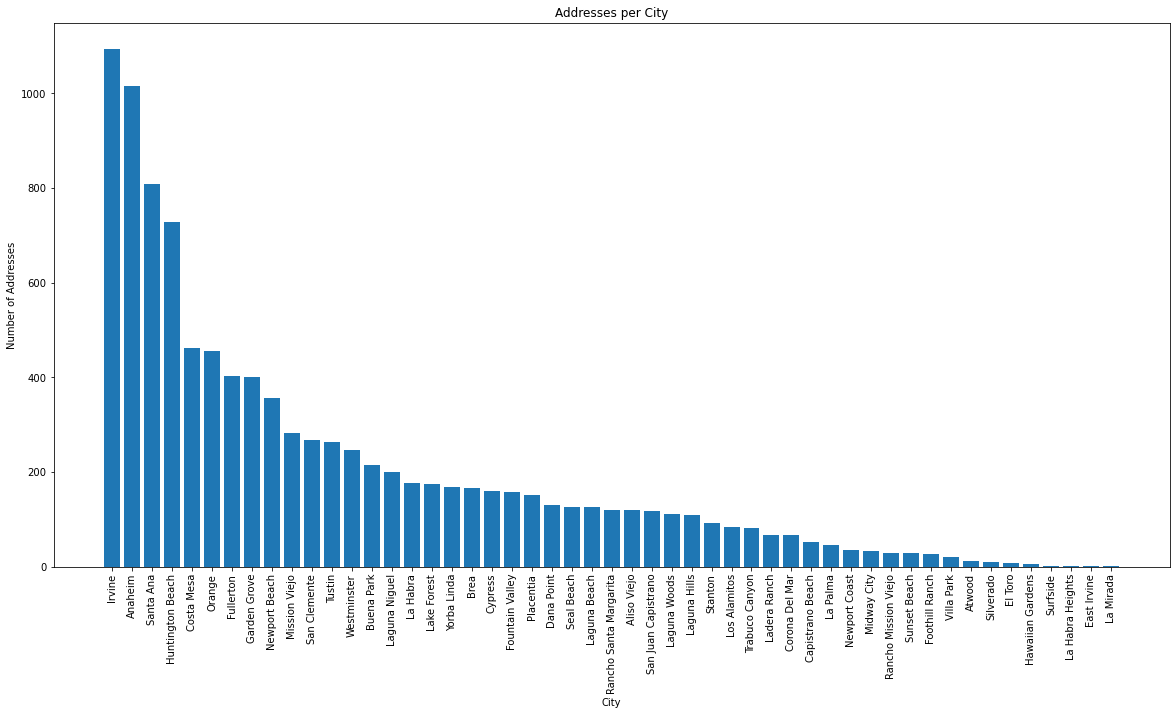

In [11]:
# Visualize how many addresses are in each city
counts = master_addr['City'].value_counts()
x = counts.index
y = counts.values
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(20, 10))  # Set the size of the figure

# Create bar plot
ax.bar(x, y)

# Add labels and title
ax.set_xlabel('City')
ax.set_ylabel('Number of Addresses')
ax.set_title('Addresses per City')

plt.xticks(rotation = 90)

plt.show()